In [ ]:
using DynamicalSystems, Plots, NPZ
import Distributions: Distribution, Normal
include("../src/KoopmanCausality.jl")
using .KoopmanCausality

In [2]:
X1_train = npzread("coupled_rossler_data/coupled_rossler_train_X1.npy")
X2_train = npzread("coupled_rossler_data/coupled_rossler_train_X2.npy")
Y1_train = npzread("coupled_rossler_data/coupled_rossler_train_Y1.npy")
Y2_train = npzread("coupled_rossler_data/coupled_rossler_train_Y2.npy")
size(X1_train)

(3, 500001)

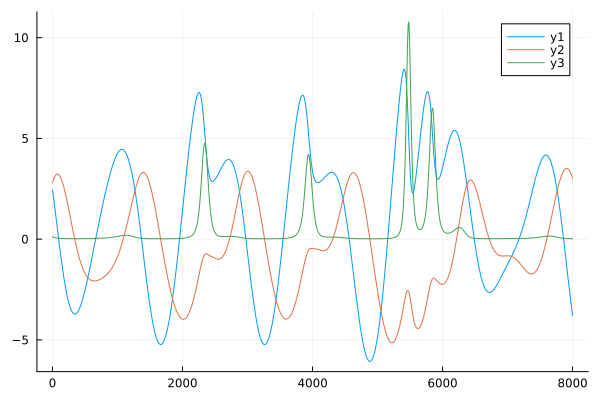

In [3]:
Plots.plot(X1_train[1, 1:8000])
Plots.plot!(X1_train[2, 1:8000])
Plots.plot!(X1_train[3, 1:8000])

In [4]:
X1_test = npzread("coupled_rossler_data/coupled_rossler_test_X1.npy")
X2_test = npzread("coupled_rossler_data/coupled_rossler_test_X2.npy")
Y1_test = npzread("coupled_rossler_data/coupled_rossler_test_Y1.npy")
Y2_test = npzread("coupled_rossler_data/coupled_rossler_test_Y2.npy")
size(X1_test)

(3, 20001, 100)

hyperparameters for brute-force optimization

In [5]:
σs = [2.0, 1.0, 0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
N_samples = 5
N_features = 150
N_vars_marg = 3
N_vars_joint = 6;

# 2 -> 1

### setup the model space for hyperparameter optimization

Randomly sample RFFs 5 times for each value of the variance hyperparameter $\sigma$ and create marginal and joint models for each of these dictionaries. 

In [41]:
expanded_σs = []
marg_models = []
joint_models = []
for σ in σs
    for _ in 1:N_samples
        push!(expanded_σs, σ)
        marg_dist = Normal(0.0, σ)
        marg_dict = RFF_dict(N_features, N_vars_marg, marg_dist)
        marg_model = causal_DMD(X1_train, Y1_train, marg_dict)
        push!(marg_models, marg_model)
        
        joint_dist = Normal(0.0, σ)
        joint_dict = RFF_dict(N_features, N_vars_joint, joint_dist)
        joint_model = causal_DMD(X1_train, X2_train, Y1_train, joint_dict)
        push!(joint_models, joint_model)
    end
end

For each test case, evaluate all of the models in the model space and take those with minimal error to compute the Koopman causality measure

In [42]:
N_tests = size(X1_test, 3)
koop_causes = Vector{Float64}(undef, N_tests)
for n in 1:N_tests
    marg_err = Inf
    joint_err = Inf
    for(marg_model, joint_model) in zip(marg_models, joint_models)
        marg = causal_eval(X1_test[:,:, n], Y1_test[:,:, n], marg_model)
        marg_err = min(marg_err, marg)
        joint = causal_eval(X1_test[:,:, n], X2_test[:,:, n], Y1_test[:,:, n], joint_model)
        joint_err = min(joint_err, joint)
    end
    kcause = marg_err - joint_err
    koop_causes[n] = kcause
end

In [43]:
maximum(koop_causes)

1.1680195022103144

In [44]:
minimum(koop_causes)

0.3078667001513874

All values are positive, so causality is positively identified for every test case

# 1 -> 2

### setup the model space for hyperparameter optimization

Randomly sample RFFs 5 times for each value of the variance hyperparameter $\sigma$ and create marginal and joint models for each of these dictionaries. 

In [29]:
expanded_σs = []
marg_models = []
joint_models = []
for σ in σs
    for _ in 1:N_samples
        push!(expanded_σs, σ)
        marg_dist = Normal(0.0, σ)
        marg_dict = RFF_dict(N_features, N_vars_marg, marg_dist)
        marg_model = causal_DMD(X2_train, Y2_train, marg_dict)
        push!(marg_models, marg_model)
        
        joint_dist = Normal(0.0, σ)
        joint_dict = RFF_dict(N_features, N_vars_joint, joint_dist)
        joint_model = causal_DMD(X2_train, X1_train, Y2_train, joint_dict)
        push!(joint_models, joint_model)
    end
end

For each test case, evaluate all of the models in the model space and take those with minimal error to compute the Koopman causality measure

In [38]:
N_tests = size(X1_test, 3)
koop_causes = Vector{Float64}(undef, N_tests)
for n in 1:N_tests
    marg_err = Inf
    joint_err = Inf
    for(marg_model, joint_model) in zip(marg_models, joint_models)
        marg = causal_eval(X2_test[:,:, n], Y2_test[:,:, n], marg_model)
        marg_err = min(marg_err, marg)
        joint = causal_eval(X2_test[:,:, n], X1_test[:,:, n], Y2_test[:,:, n], joint_model)
        joint_err = min(joint_err, joint)
    end
    kcause = marg_err - joint_err
    koop_causes[n] = kcause
end

In [39]:
maximum(koop_causes)

-0.3936308418609381

In [40]:
minimum(koop_causes)

-0.7701941656362805

All values are negative, so causality is correctly not identified in all test cases